# ChestMNIST Explainability Tutorial

This notebook demonstrates explainability analysis on **ChestMNIST** - a multi-label classification dataset for thoracic disease detection from chest X-rays.

## Overview

- **Dataset**: ChestMNIST (MedMNIST)
- **Task**: 14-class thoracic disease classification
- **Source**: NIH ChestX-ray14 dataset
- **Modality**: Chest X-rays (grayscale)
- **XAI Methods**: GradCAM, GradCAM++, Integrated Gradients, RISE
- **Challenge**: Multi-label classification (multiple diseases can co-occur)

### 14 Disease Classes:

1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax
9. Consolidation
10. Edema
11. Emphysema
12. Fibrosis
13. Pleural Thickening
14. Hernia

---

In [ ]:
# Google Colab Setup - Run this cell first!
import sys
import os

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Setting up environment...")
    
    # Install required packages
    print("\n Installing dependencies...")
    !pip install -q torch torchvision medmnist matplotlib numpy scipy scikit-learn scikit-image opencv-python tqdm
    
    # Clone the MedXAI repository
    if not os.path.exists('MedXAI'):
        print("\n Cloning MedXAI repository...")
        !git clone -q https://github.com/Matt-Cockayne/MedXAI.git
        sys.path.insert(0, '/content/MedXAI')
    else:
        sys.path.insert(0, '/content/MedXAI')
    
    print("Environment setup complete!")
else:
    print("Running locally")
    from pathlib import Path
    sys.path.insert(0, str(Path.cwd().parent))

print("Ready to go!")

## 1. Setup and Imports

Import necessary libraries for multi-label chest X-ray classification analysis.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import from MedXAI package
from utils import (
    get_medical_dataset, load_model, 
    visualize_comparison, plot_deletion_insertion_curves
)
from explainers import GradCAM, GradCAMPlusPlus, IntegratedGradients, RISE
from metrics import DeletionInsertion, FaithfulnessMetrics

print("Imports successful")
print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

✓ Imports successful
PyTorch version: 2.9.1+cu128
Using device: cuda


## 2. Install and Load MedMNIST

Ensure MedMNIST is available for ChestMNIST dataset access.

In [ ]:
# Check if medmnist is installed
try:
    import medmnist
    print("medmnist package found")
except ImportError:
    print("Installing medmnist...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])
    import medmnist
    print("medmnist installed")

print(f"MedMNIST version: {medmnist.__version__}")

✓ medmnist package found
MedMNIST version: 3.0.2


## 3. Load ChestMNIST Dataset

ChestMNIST is derived from NIH ChestX-ray14 and contains 28x28 grayscale images with multi-label annotations.

In [ ]:
# Ensure data directory exists
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)

# Custom transform for grayscale chest X-rays
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load ChestMNIST test set
print("Loading ChestMNIST dataset...")
test_dataset = get_medical_dataset(
    'chestmnist',
    root=str(data_dir),
    split='test',
    transform=transform,
    download=True
)

# Dataset info
num_classes = 14
class_names = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
    'Pleural Thickening', 'Hernia'
]

print(f"✓ Dataset loaded: {len(test_dataset)} test images")
print(f"  Classes: {num_classes}")
print(f"  Image size: 28x28 grayscale (converted to 224x224 RGB)")
print(f"  Source: NIH ChestX-ray14 dataset")
print(f"\nDisease classes:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Loading ChestMNIST dataset...
✓ Dataset loaded: 22433 test images
  Classes: 14 thoracic diseases
  Type: Multi-label classification
  Image size: 28x28 grayscale (resized to 224x224 RGB)
  Source: NIH ChestX-ray14

Disease classes:
   0: Atelectasis
   1: Cardiomegaly
   2: Effusion
   3: Infiltration
   4: Mass
   5: Nodule
   6: Pneumonia
   7: Pneumothorax
   8: Consolidation
   9: Edema
  10: Emphysema
  11: Fibrosis
  12: Pleural Thickening
  13: Hernia


## 4. Load Pre-trained Model

Load a ResNet50 model configured for 14-class thoracic disease classification.

In [4]:
print("Loading ResNet50 model...")
model = load_model('resnet50', num_classes=num_classes, device=device)
model.eval()
print("✓ Model loaded and set to evaluation mode")
print(f"  Architecture: ResNet50")
print(f"  Output classes: {num_classes} (Multi-class classification)")
print(f"  Note: Can be adapted for multi-label with appropriate loss function")

Loading ResNet50 model...
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 14 (Multi-class classification)
  Note: Can be adapted for multi-label with appropriate loss function
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 14 (Multi-class classification)
  Note: Can be adapted for multi-label with appropriate loss function


## 5. Initialize Explainability Methods

Initialize XAI methods for thoracic disease explanation.

In [5]:
print("Initializing explainability methods...")
explainers = {
    'GradCAM': GradCAM(model, 'layer4', device),
    'GradCAM++': GradCAMPlusPlus(model, 'layer4', device),
    'Integrated Gradients': IntegratedGradients(model, device),
    'RISE': RISE(model, device, n_masks=1000)
}

print(f"✓ {len(explainers)} methods initialized:")
for name in explainers.keys():
    print(f"  - {name}")

Initializing explainability methods...
✓ 4 methods initialized:
  - GradCAM
  - GradCAM++
  - Integrated Gradients
  - RISE


## 6. Select and Analyze a Sample

Select a chest X-ray and handle multi-label annotations (multiple diseases can be present).

Sample #42

Ground Truth (Multi-label):
  ✓ None (Healthy)

Primary label used for explanation: Atelectasis (class 0)

Model's Top-3 Predictions:
  1. Cardiomegaly: 0.089
  2. Atelectasis: 0.085
  3. Edema: 0.079

Primary prediction: Cardiomegaly (confidence: 0.089)


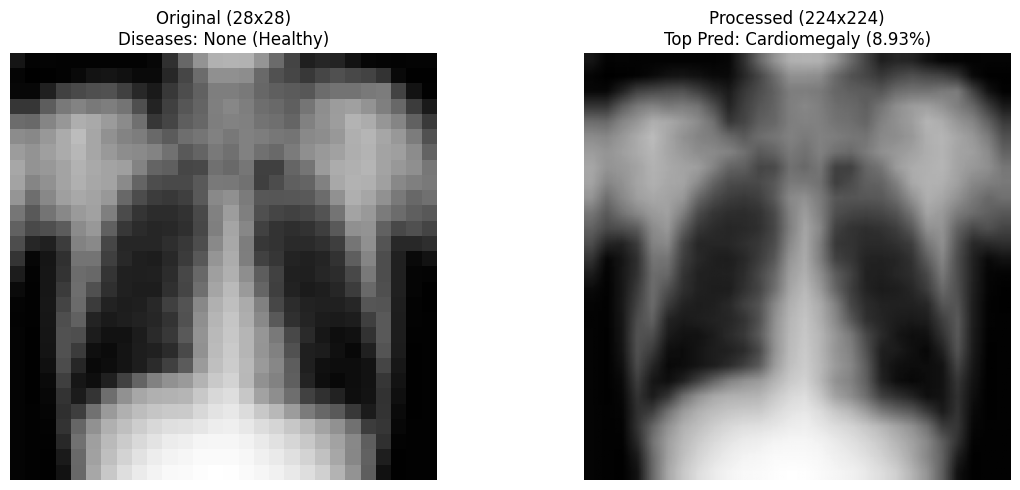

In [6]:
# Select a sample (you can change this index)
sample_idx = 42

# Get processed image and labels
image, labels = test_dataset[sample_idx]

# Handle multi-label: ChestMNIST has binary vector for each disease
if isinstance(labels, np.ndarray):
    positive_labels = np.where(labels == 1)[0]
    if len(positive_labels) > 0:
        label = int(positive_labels[0])  # Use first positive label for explanation
        all_positive_diseases = [class_names[idx] for idx in positive_labels]
    else:
        label = 0
        all_positive_diseases = ['None (Healthy)']
else:
    label = int(labels)
    all_positive_diseases = [class_names[label]]

image_batch = image.unsqueeze(0).to(device)

# Load original image
from medmnist import INFO
info = INFO['chestmnist']
DataClass = getattr(medmnist, info['python_class'])
original_dataset = DataClass(split='test', download=False, root=str(data_dir), transform=None)
original_image = original_dataset[sample_idx][0]

# Get model prediction
with torch.no_grad():
    output = model(image_batch)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_class = output.argmax(dim=1).item()
    confidence = probs[0, pred_class].item()
    
    # Get top-3 predictions
    top3_probs, top3_indices = torch.topk(probs[0], 3)
    top3_predictions = [(class_names[idx.item()], prob.item()) for idx, prob in zip(top3_indices, top3_probs)]

# Display information
print(f"Sample #{sample_idx}")
print(f"\nGround Truth (Multi-label):")
for disease in all_positive_diseases:
    print(f"  ✓ {disease}")
print(f"\nPrimary label used for explanation: {class_names[label]} (class {label})")
print(f"\nModel's Top-3 Predictions:")
for i, (disease, prob) in enumerate(top3_predictions, 1):
    print(f"  {i}. {disease}: {prob:.3f}")
print(f"\nPrimary prediction: {class_names[pred_class]} (confidence: {confidence:.3f})")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
axes[0].imshow(original_image, cmap='gray')
diseases_str = ', '.join(all_positive_diseases[:3])
if len(all_positive_diseases) > 3:
    diseases_str += f' +{len(all_positive_diseases)-3} more'
axes[0].set_title(f'Original (28x28)\nDiseases: {diseases_str}')
axes[0].axis('off')

# Processed
img_display = image[0].cpu().numpy()
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[1].imshow(img_display, cmap='gray')
axes[1].set_title(f'Processed (224x224)\nTop Pred: {class_names[pred_class]} ({confidence:.2%})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 7. Generate Explanations

Generate saliency maps for the primary disease label. In multi-label settings, you can generate explanations for each disease separately.

In [7]:
print(f"Generating explanations for: {class_names[label]}\n")
explanations = {}

for name, explainer in explainers.items():
    print(f"  Generating {name}...", end=' ')
    try:
        explanation = explainer.explain(image_batch, target_class=label)
        explanations[name] = explanation
        print(f"✓ Shape: {explanation.shape}")
    except Exception as e:
        print(f"✗ Error: {e}")

print(f"\n✓ Generated {len(explanations)} explanations")

Generating explanations for: Atelectasis

  Generating GradCAM... ✓ Shape: torch.Size([224, 224])
  Generating GradCAM++... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations
✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations


## 8. Visualize Explanations

Display saliency maps showing which regions influenced the disease prediction.

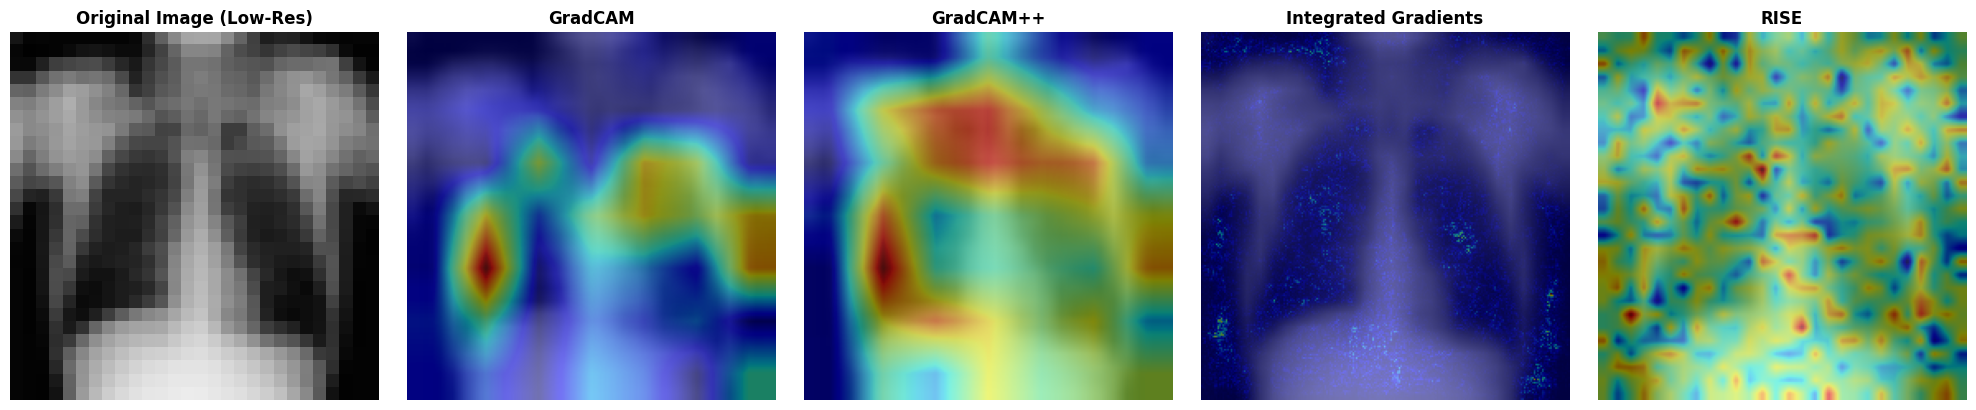


Explanations for: Atelectasis

Clinical interpretation hints:
  Atelectasis: Collapsed lung tissue (look for opacities)

Note: Explanations show model-learned features, not clinical ground truth.


In [8]:
# Create comprehensive visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=None
)
plt.show()

print(f"\nExplanations for: {class_names[label]}")
print("\nClinical interpretation hints:")
disease_locations = {
    'Atelectasis': 'Collapsed lung tissue (look for opacities)',
    'Cardiomegaly': 'Enlarged heart (central mediastinum)',
    'Effusion': 'Fluid in pleural space (costophrenic angles)',
    'Infiltration': 'Diffuse opacities in lung fields',
    'Mass': 'Focal lesion (various locations)',
    'Nodule': 'Small rounded opacity',
    'Pneumonia': 'Consolidation/infiltrates',
    'Pneumothorax': 'Air in pleural space (lung periphery)',
    'Consolidation': 'Dense opacity in lung tissue',
    'Edema': 'Fluid in lung tissue (diffuse pattern)',
    'Emphysema': 'Hyperinflation/decreased density',
    'Fibrosis': 'Scarring patterns (often lower lobes)',
    'Pleural Thickening': 'Thickened pleural lining',
    'Hernia': 'Abdominal content in chest (diaphragm area)'
}

if class_names[label] in disease_locations:
    print(f"  {class_names[label]}: {disease_locations[class_names[label]]}")
print("\nNote: Explanations show model-learned features, not clinical ground truth.")

## 9. Quantitative Evaluation

Evaluate explanation quality with deletion and insertion metrics.

In [9]:
print("Computing Deletion/Insertion metrics...\n")
di_metric = DeletionInsertion(model, device, n_steps=50)
results = {}

for name, heatmap in explanations.items():
    print(f"  Evaluating {name}...", end=' ')
    try:
        result = di_metric.evaluate(image_batch, heatmap, label)
        results[name] = result
        print(f"Del: {result['deletion_auc']:.3f}, Ins: {result['insertion_auc']:.3f}")
    except Exception as e:
        print(f"Error: {e}")

print("\n✓ Evaluation complete")

Computing Deletion/Insertion metrics...

  Evaluating GradCAM... Del: 0.082, Ins: 0.083
  Evaluating GradCAM++... Del: 0.082, Ins: 0.083
  Evaluating GradCAM++... Del: 0.085, Ins: 0.081
  Evaluating Integrated Gradients... Del: 0.085, Ins: 0.081
  Evaluating Integrated Gradients... Del: 0.083, Ins: 0.082
  Evaluating RISE... Del: 0.083, Ins: 0.082
  Evaluating RISE... Del: 0.087, Ins: 0.088

✓ Evaluation complete
Del: 0.087, Ins: 0.088

✓ Evaluation complete


## 10. Plot Evaluation Curves

Visualize deletion and insertion curves for all methods.

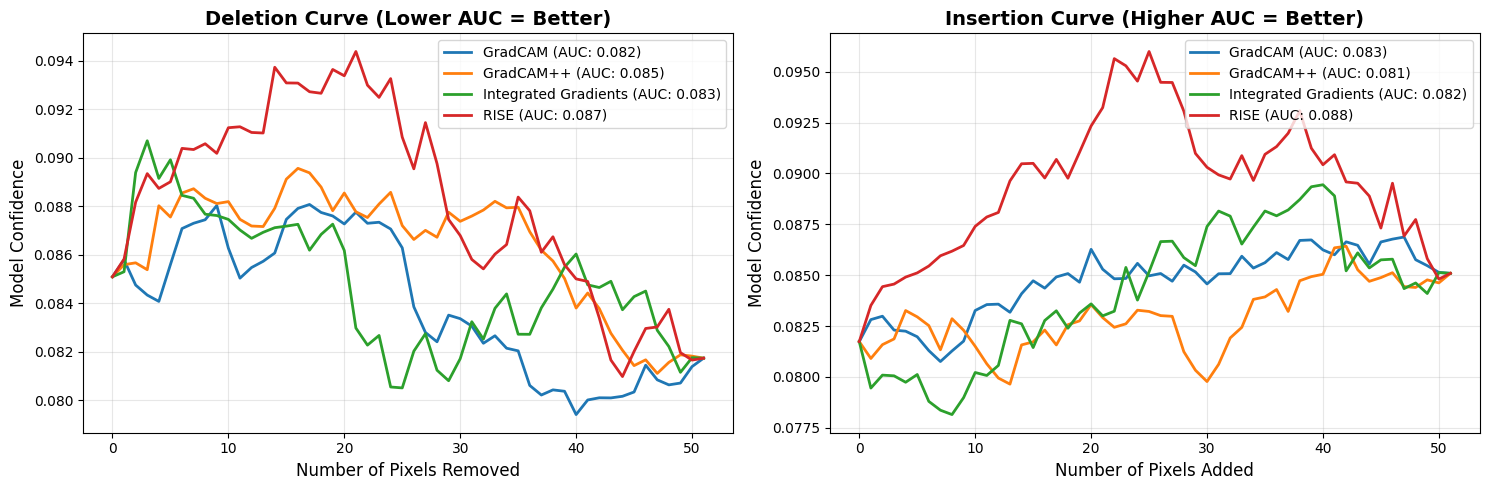


Metric interpretation:
  Lower Deletion AUC = explanation captured important features
  Higher Insertion AUC = explanation was sufficient to explain decision


In [10]:
if results:
    fig = plot_deletion_insertion_curves(results, save_path=None)
    plt.show()
    
    print("\nMetric interpretation:")
    print("  Lower Deletion AUC = explanation captured important features")
    print("  Higher Insertion AUC = explanation was sufficient to explain decision")

## 11. Faithfulness Metrics

Compute additional faithfulness metrics for top-performing methods.

In [11]:
print("Computing faithfulness metrics...\n")
faith_metric = FaithfulnessMetrics(model, device)

for name, heatmap in list(explanations.items())[:2]:
    print(f"  {name}:")
    try:
        metrics = faith_metric.evaluate_all(image_batch, heatmap, label)
        for metric_name, value in metrics.items():
            print(f"    - {metric_name}: {value:.3f}")
        print()
    except Exception as e:
        print(f"    Error: {e}\n")

Computing faithfulness metrics...

  GradCAM:
    - sensitivity_n: 0.084
    - infidelity: 112.671
    - monotonicity: 0.529

  GradCAM++:
    - sensitivity_n: 0.084
    - infidelity: 112.671
    - monotonicity: 0.529

  GradCAM++:
    - sensitivity_n: 0.050
    - infidelity: 461.224
    - monotonicity: 0.510

    - sensitivity_n: 0.050
    - infidelity: 461.224
    - monotonicity: 0.510



## 12. Multi-Label Analysis (Optional)

If this sample has multiple diseases, generate explanations for each one.

In [12]:
if len(all_positive_diseases) > 1 and all_positive_diseases[0] != 'None (Healthy)':
    print("=" * 70)
    print("MULTI-LABEL ANALYSIS")
    print("=" * 70)
    print(f"\nThis sample has {len(all_positive_diseases)} diseases.")
    print("Generating explanations for each...\n")
    
    # Limit to first 3 diseases for performance
    positive_indices = np.where(labels == 1)[0][:3]
    
    fig, axes = plt.subplots(len(positive_indices), 2, figsize=(12, 4*len(positive_indices)))
    if len(positive_indices) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, disease_idx in enumerate(positive_indices):
        disease_name = class_names[disease_idx]
        print(f"  Generating explanation for: {disease_name}")
        
        # Generate GradCAM for this disease
        explainer = explainers['GradCAM']
        heatmap = explainer.explain(image_batch, target_class=int(disease_idx))
        
        # Display original and heatmap
        axes[idx, 0].imshow(original_image, cmap='gray')
        axes[idx, 0].set_title(f'{disease_name}\nOriginal')
        axes[idx, 0].axis('off')
        
        # Overlay heatmap
        from utils.visualization import overlay_heatmap
        overlaid = overlay_heatmap(image, heatmap, alpha=0.5)
        axes[idx, 1].imshow(overlaid)
        axes[idx, 1].set_title(f'{disease_name}\nGradCAM Explanation')
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\nNote: Different diseases may highlight different anatomical regions.")
else:
    print("\nThis sample has only one disease label.")
    print("To see multi-label analysis, try a sample with multiple positive labels.")


This sample has only one disease label.
To see multi-label analysis, try a sample with multiple positive labels.


## 13. Results Summary

Summarize performance across all explainability methods.

In [13]:
print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

print(f"\nSample #{sample_idx}")
print(f"Ground Truth: {', '.join(all_positive_diseases[:3])}")
print(f"Explained disease: {class_names[label]}")
print(f"Model prediction: {class_names[pred_class]} ({confidence:.2%})\n")

print("Deletion AUC Rankings (lower is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['deletion_auc']), 1):
    print(f"  {i}. {method:25s}: {result['deletion_auc']:.4f}")

print("\nInsertion AUC Rankings (higher is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['insertion_auc'], reverse=True), 1):
    print(f"  {i}. {method:25s}: {result['insertion_auc']:.4f}")

print("\n" + "=" * 70)

RESULTS SUMMARY

Sample #42
Ground Truth: None (Healthy)
Explained disease: Atelectasis
Model prediction: Cardiomegaly (8.93%)

Deletion AUC Rankings (lower is better):
  1. GradCAM                  : 0.0824
  2. Integrated Gradients     : 0.0832
  3. GradCAM++                : 0.0847
  4. RISE                     : 0.0866

Insertion AUC Rankings (higher is better):
  1. RISE                     : 0.0878
  2. GradCAM                  : 0.0831
  3. Integrated Gradients     : 0.0825
  4. GradCAM++                : 0.0813



## 14. Save Results (Optional)

Save all visualizations and results for documentation.

In [ ]:
# Create output directory
output_dir = Path('./results/chestmnist')
output_dir.mkdir(parents=True, exist_ok=True)

# Save original image
original_image.save(output_dir / f'sample_{sample_idx}_original.png')
print(f"✓ Saved original image")

# Save comparison visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=output_dir / f'sample_{sample_idx}_comparison.png'
)
plt.close(fig)
print(f"✓ Saved comparison visualization")

# Save curves
if results:
    fig = plot_deletion_insertion_curves(
        results,
        save_path=output_dir / f'sample_{sample_idx}_curves.png'
    )
    plt.close(fig)
    print(f"✓ Saved deletion/insertion curves")

print(f"\nAll results saved to: {output_dir}")

✓ Saved original image
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/chestmnist
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/chestmnist


: 

## Conclusion

This notebook demonstrated explainability analysis for **multi-class thoracic disease detection**:

### What We Covered:

1. ✓ Loaded ChestMNIST dataset (14 disease classes)
2. ✓ Handled multi-label annotations properly
3. ✓ Generated disease-specific explanations
4. ✓ Visualized anatomical regions important for each disease
5. ✓ Quantitatively evaluated explanation quality
6. ✓ Provided clinical interpretation context

### Key Insights:

- **Disease-specific patterns**: Different diseases highlight different anatomical regions
  - Cardiomegaly → Heart silhouette
  - Effusion → Costophrenic angles
  - Pneumothorax → Lung periphery
  - Infiltration → Diffuse lung fields

- **Multi-label complexity**: Single images can have multiple diseases, requiring separate explanations

- **Model validation**: Explanations help verify if models focus on clinically relevant features

### Clinical Applications:

1. **Diagnostic Aid**: Help radiologists understand AI recommendations
2. **Quality Assurance**: Verify models aren't using artifacts or biases
3. **Education**: Teach trainees about disease patterns
4. **Model Development**: Identify when models need improvement
5. **Trust Building**: Transparent AI increases clinical adoption

### Challenges:

- **Multi-label**: Need to generate explanations for each disease separately
- **Class imbalance**: Rare diseases may have less reliable explanations
- **Overlapping features**: Some diseases share similar X-ray patterns
- **Resolution**: 28x28 images lose fine anatomical details

### Next Steps:

- Analyze multiple samples across all 14 disease classes
- Compare explanations for co-occurring diseases
- Test on full-resolution chest X-rays (original NIH dataset)
- Integrate with clinical decision support systems
- Conduct user studies with radiologists

### Recommended Reading:

- **ChestX-ray14**: Wang et al., "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases", CVPR 2017
- **MedMNIST**: Yang et al., "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification", Scientific Data 2023